In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.initializers import he_normal
%matplotlib inline

# Display only top 5 and bottom 5 rows
pd.set_option('display.max_rows', 10)

Using TensorFlow backend.


In [2]:
# Set random seed for reproducibility
# Note: CuDNN is usually non-deterministic
# (can't determine which of the ~3000 threads finish earlier)
# And floating points reduction is not perfectly associative due to ULP rounding
import numpy as np
np.random.seed(1337)
import tensorflow as tf
tf.set_random_seed(1337)

In [3]:
df_train = pd.read_csv('./data/train_aWnotuB.csv', parse_dates=[0], infer_datetime_format=True)
df_train

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


# Preprocessing

In [4]:
train = df_train.pivot(index='DateTime',columns='Junction', values='Vehicles')
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,NaN
2015-11-01 01:00:00,13.0,6.0,7.0,NaN
2015-11-01 02:00:00,10.0,5.0,5.0,NaN
2015-11-01 03:00:00,7.0,6.0,1.0,NaN
2015-11-01 04:00:00,9.0,7.0,2.0,NaN
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


## Remove Nan (0 vehicle)

In [5]:
train = train.fillna(0)

## Normalize the data on 0, 1

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [7]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))

In [8]:
train[train.columns] = scaler.fit_transform(train[train.columns])

In [9]:
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,0.066225,0.106383,0.044693,0.000000
2015-11-01 01:00:00,0.052980,0.106383,0.033520,0.000000
2015-11-01 02:00:00,0.033113,0.085106,0.022346,0.000000
2015-11-01 03:00:00,0.013245,0.106383,0.000000,0.000000
2015-11-01 04:00:00,0.026490,0.127660,0.005587,0.000000
...,...,...,...,...
2017-06-30 19:00:00,0.662252,0.702128,0.178771,0.305556
2017-06-30 20:00:00,0.602649,0.723404,0.167598,0.833333
2017-06-30 21:00:00,0.562914,0.638298,0.150838,0.444444


# Generate rolling forecast features

In [10]:
nb_forecast_per_junction = 24 * (31 + 31 + 30 + 31) # Days in jul + aug + sep + oct

In [11]:
nb_forecast_per_junction

2952

In [12]:
nb_forecast_per_junction * 4

11808

That will certainly not fit in the GPU VRAM --> We will get inspiration from seq2seq models and do a sliding window of time that matches a week.

In [13]:
num_feats = 4
seq_len = 24 * 2 # We predict 48 hours
num_outputs = 4
num_hidden = 4 # We keep 8 days of state
bs = 128
epochs = 500
LOG_PATH = "checkpoints/" + time.strftime("%Y-%m-%d_%H%M-")+"s2s-concat-Conv1d.hdf5"

# pred_len = int(nb_forecast_per_junction / seq_len)
# assert nb_forecast_per_junction % seq_len == 0 # Check that we can split forecast into even sequences
# print(pred_len)

We originally had 14592 rows, we will generate sequences of predictions from it.

In [14]:
def make_input_seqs(data, seq_len, train_split=0.9):
    seq_len = seq_len + 1
    result = []
    for index in range(len(data) - seq_len):
        result.append(data[index: index + seq_len, :])
    result = np.array(result) # shape (14423, 168, 4)
    train_ind = round(train_split * result.shape[0])
    train = result[:int(train_ind), :, :]
    x_train = train[:, :-1, :]
    y_train = train[:, -1, :]
    x_test = result[int(train_ind):, :-1, :]
    y_test = result[int(train_ind):, -1, :]

    return [x_train, y_train, x_test, y_test]

In [15]:
X_train, y_train, X_test, y_test = make_input_seqs(train.values, seq_len)

# Generate model

## Loss function

In [16]:
import keras.backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

## Neural net

In [17]:
from keras.optimizers import adam, rmsprop, sgd

### Optimizer

In [18]:
adam = adam(clipvalue=0.5) # Clip to avoid exploding gradients
# rmsprop = rmsprop(lr = 0.005, decay = 0.05)
# sgd = sgd(lr = 0.005, decay = 0.05)

optim = adam

In [19]:
from keras.layers import *
from keras.layers.core import *
from keras.layers.recurrent import *
from keras.models import *
from keras.activations import *

### Model

In [20]:
def attention_n_days_ago(inputs, days_ago):
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = days_ago * 24
    suffix = str(days_ago) +'_days'
    
    # We compute the attention over the seq_len
    a = Permute((2, 1),
                name='Attn_Permute1_' + suffix)(inputs)
    a = Dense(time_steps,
              activation='softmax',
              name='Attn_DenseClf_' + suffix)(a)
    
    # Now we convolute so that it average over the whole time window
    feats_depth = int(inputs.shape[2])
    avg = Lambda(lambda x: K.expand_dims(x, axis = 1),
                 name='Attn_Unsqueeze_' + suffix)(inputs)
    avg = SeparableConv2D(feats_depth, (1,1),
                          name='Attn_DepthConv_' + suffix)(avg)
    avg = Lambda(lambda x: K.squeeze(x, 1),
                 name='Attn_Squeeze_'+ str(days_ago) + '_days')(avg)
    
    
    a_probs = Permute((2, 1),
                      name='Attn_Permute1_' + suffix)(avg)
    # out = Multiply(name='Attn_mul_'+ suffix)([inputs, a_probs])
    out = Concatenate(name='Attn_cat_'+ suffix)([inputs, a_probs])
    return out

In [21]:
def Net(num_feats, seq_len, num_hidden, num_outputs):
    x = Input(shape=(seq_len, num_feats))

    # Encoder RNNs
    enc = CuDNNGRU(seq_len,
                   return_sequences=True,
                   stateful = False,
                   name = 'Encoder_RNN')(x)
    
    # Attention decoders (lag features)
    attention_0d = attention_n_days_ago(enc, 0)
    attention_1d = attention_n_days_ago(enc, 1)
    attention_2d = attention_n_days_ago(enc, 2)
    attention_4d = attention_n_days_ago(enc, 4)
    attention_1w = attention_n_days_ago(enc, 7)
    attention_2w = attention_n_days_ago(enc, 14)
    attention_1m = attention_n_days_ago(enc, 30)
    attention_2m = attention_n_days_ago(enc, 60)
    attention_1q = attention_n_days_ago(enc, 92)
    attention_6m = attention_n_days_ago(enc, 184)
    attention_3q = attention_n_days_ago(enc, 276)
    attention_1y = attention_n_days_ago(enc, 365)
    
    att = Concatenate(name='attns_cat', axis = 1)([attention_0d,
                                                   attention_1d,
                                                   attention_2d,
                                                   attention_4d,
                                                   attention_1w,
                                                   attention_2w,
                                                   attention_1m,
                                                   attention_2m,
                                                   attention_1q,
                                                   attention_6m,
                                                   attention_3q,
                                                   attention_1y])
    
    # How to merge? concat, mul, add, use Dense Layer or convolution ?
        
    att = Dense(seq_len, activation=None, name='Dense_merge_attns')(att)
    # att = Lambda(lambda x: softmax(x, axis = 1),
    #              name='Dense_merge_3D_softmax')(att) # Flatten along the concat axis
    
    # Decoder RNN
    dec = CuDNNGRU(num_hidden,
                   return_sequences=False,
                   stateful = False,
                   name='Decoder_RNN')(att)

    # Regressor
    # Note that Dense is automatically TimeDistributed in Keras 2
    out = Dense(num_outputs, activation=None,
                name = 'Classifier')(dec) # no activation for regression
    
    model = Model(inputs=x, outputs=out)
                          
    model.compile(loss= root_mean_squared_error, optimizer = optim)
    return model

In [22]:
model = Net(num_feats, seq_len, num_hidden, num_outputs)

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 4)        0                                            
__________________________________________________________________________________________________
Encoder_RNN (CuDNNGRU)          (None, 48, 48)       7776        input_1[0][0]                    
__________________________________________________________________________________________________
Attn_Unsqueeze_0_days (Lambda)  (None, 1, 48, 48)    0           Encoder_RNN[0][0]                
__________________________________________________________________________________________________
Attn_Unsqueeze_1_days (Lambda)  (None, 1, 48, 48)    0           Encoder_RNN[0][0]                
__________________________________________________________________________________________________
Attn_Unsqu

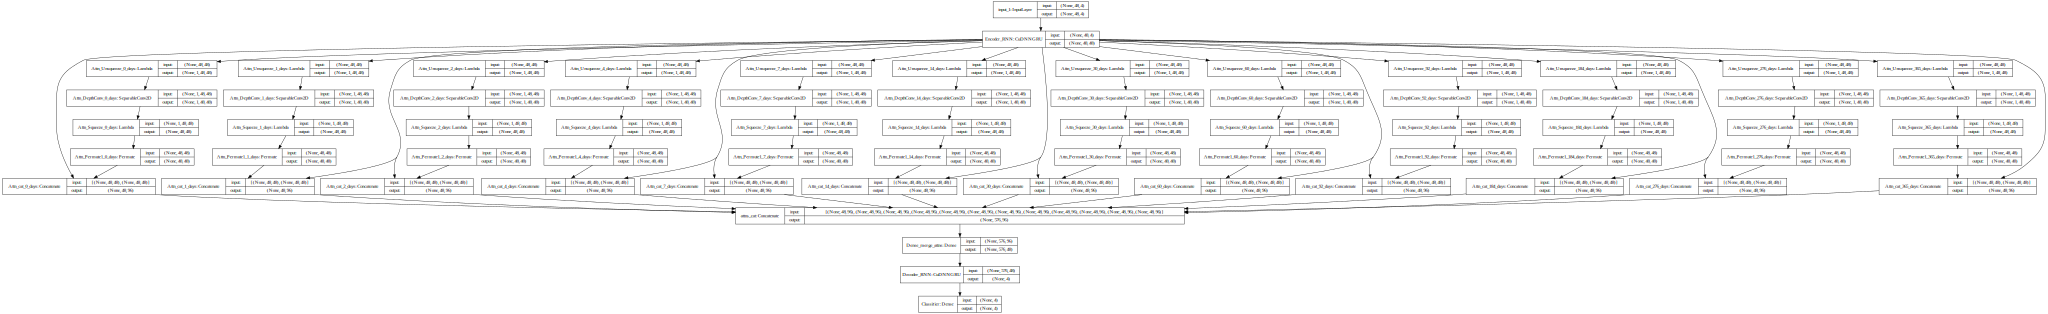

In [24]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Callbacks

In [25]:
from keras.callbacks import History, ModelCheckpoint, CSVLogger, EarlyStopping

In [26]:
history = History()
checkpointer = ModelCheckpoint(filepath= LOG_PATH,
                               verbose=1, save_best_only=False)
csv_logger = CSVLogger("checkpoints/" + time.strftime("%Y-%m-%d_%H%M-")+'training.log')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')

# Training

In [27]:
print(X_train.shape)

(13089, 48, 4)


In [28]:
model.fit(X_train, y_train,
          batch_size=bs,
          epochs=epochs,
          validation_split=0.05,
          shuffle=False,
          callbacks=[history,checkpointer,csv_logger,early_stop])

Train on 12434 samples, validate on 655 samples
Epoch 1/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0548Epoch 00001: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0549 - val_loss: 0.0717
Epoch 2/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0455Epoch 00002: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0456 - val_loss: 0.0612
Epoch 3/500

 2944/12434 [======>.......................] - ETA: 3s - loss: 0.0430


12416/12434 [============================>.] - ETA: 0s - loss: 0.0430Epoch 00003: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0430 - val_loss: 0.0584
Epoch 4/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0398Epoch 00004: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0399 - val_loss: 0.0579
Epoch 5/500

 6272/12434 [==============>...............] - ETA: 2s - loss: 0.0291


12416/12434 [============================>.] - ETA: 0s - loss: 0.0372Epoch 00005: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0373 - val_loss: 0.0562
Epoch 6/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0376Epoch 00006: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0376 - val_loss: 0.0578
Epoch 7/500

 9600/12434 [======================>.......] - ETA: 1s - loss: 0.0297


12416/12434 [============================>.] - ETA: 0s - loss: 0.0362Epoch 00007: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0362 - val_loss: 0.0543
Epoch 8/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0350Epoch 00008: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0350 - val_loss: 0.0516
Epoch 9/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0334Epoch 00009: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0334 - val_loss: 0.0495
Epoch 10/500



12416/12434 [============================>.] - ETA: 0s - loss: 0.0328Epoch 00010: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0329 - val_loss: 0.0486
Epoch 11/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0321Epoch 00011: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0322 - val_loss: 0.0479
Epoch 12/500

 3200/12434 [======>.......................] - ETA: 3s - loss: 0.0271


12416/12434 [============================>.] - ETA: 0s - loss: 0.0317Epoch 00012: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0317 - val_loss: 0.0478
Epoch 13/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0312Epoch 00013: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0313 - val_loss: 0.0472
Epoch 14/500

 6528/12434 [==============>...............] - ETA: 2s - loss: 0.0259


12416/12434 [============================>.] - ETA: 0s - loss: 0.0309Epoch 00014: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0310 - val_loss: 0.0471
Epoch 15/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0306Epoch 00015: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0307 - val_loss: 0.0467
Epoch 16/500

 9856/12434 [======================>.......] - ETA: 1s - loss: 0.0260


12416/12434 [============================>.] - ETA: 0s - loss: 0.0304Epoch 00016: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0304 - val_loss: 0.0464
Epoch 17/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0302Epoch 00017: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0303 - val_loss: 0.0463
Epoch 18/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0300Epoch 00018: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0300 - val_loss: 0.0459
Epoch 19/500

  128/12434 [..............................] - ETA: 4s - loss: 0.0274


12416/12434 [============================>.] - ETA: 0s - loss: 0.0299Epoch 00019: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0299 - val_loss: 0.0459
Epoch 20/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0298Epoch 00020: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0299 - val_loss: 0.0458
Epoch 21/500

 3456/12434 [=======>......................] - ETA: 3s - loss: 0.0251


12416/12434 [============================>.] - ETA: 0s - loss: 0.0297Epoch 00021: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0297 - val_loss: 0.0454
Epoch 22/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0297Epoch 00022: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0297 - val_loss: 0.0455
Epoch 23/500

 6784/12434 [===============>..............] - ETA: 2s - loss: 0.0249


12416/12434 [============================>.] - ETA: 0s - loss: 0.0296Epoch 00023: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0296 - val_loss: 0.0451
Epoch 24/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0296Epoch 00024: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0297 - val_loss: 0.0451
Epoch 25/500

10112/12434 [=======================>......] - ETA: 1s - loss: 0.0253


12416/12434 [============================>.] - ETA: 0s - loss: 0.0297Epoch 00025: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0297 - val_loss: 0.0451
Epoch 26/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0296Epoch 00026: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0297 - val_loss: 0.0445
Epoch 27/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0296Epoch 00027: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0297 - val_loss: 0.0448
Epoch 28/500

  384/12434 [..............................] - ETA: 4s - loss: 0.0246


12416/12434 [============================>.] - ETA: 0s - loss: 0.0298Epoch 00028: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0298 - val_loss: 0.0443
Epoch 29/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0297Epoch 00029: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0297 - val_loss: 0.0449
Epoch 30/500

 3712/12434 [=======>......................] - ETA: 3s - loss: 0.0247


12416/12434 [============================>.] - ETA: 0s - loss: 0.0293Epoch 00030: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0293 - val_loss: 0.0444
Epoch 31/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0291Epoch 00031: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0291 - val_loss: 0.0441
Epoch 32/500

 7040/12434 [===============>..............] - ETA: 2s - loss: 0.0246


12416/12434 [============================>.] - ETA: 0s - loss: 0.0291Epoch 00032: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0291 - val_loss: 0.0441
Epoch 33/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0291Epoch 00033: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0291 - val_loss: 0.0442
Epoch 34/500

10368/12434 [========================>.....] - ETA: 1s - loss: 0.0256


12416/12434 [============================>.] - ETA: 0s - loss: 0.0291Epoch 00034: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0291 - val_loss: 0.0440
Epoch 35/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0291Epoch 00035: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0292 - val_loss: 0.0442
Epoch 36/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0290Epoch 00036: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0291 - val_loss: 0.0440
Epoch 37/500

  640/12434 [>.............................] - ETA: 4s - loss: 0.0250


12416/12434 [============================>.] - ETA: 0s - loss: 0.0292Epoch 00037: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0292 - val_loss: 0.0443
Epoch 38/500

12416/12434 [============================>.] - ETA: 0s - loss: 0.0289Epoch 00038: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0290 - val_loss: 0.0442
Epoch 39/500

 3968/12434 [========>.....................] - ETA: 3s - loss: 0.0244


12416/12434 [============================>.] - ETA: 0s - loss: 0.0290Epoch 00039: saving model to checkpoints/2017-11-18_2349-s2s-concat-Conv1d.hdf5

12434/12434 [==============================] - ETA: 0s - loss: 0.0291 - val_loss: 0.0444
Epoch 00039: early stopping


# Saving RNN states

In [29]:
def get_states(model):
    return [K.get_value(s) for s,_ in model.state_updates]

def set_states(model, states):
    for (d,_), s in zip(model.state_updates, states):
        K.set_value(d, s)

In [30]:
RNNs_states = get_states(model)

# Validation

## Validation by feeding truth values

In [31]:
def plot_preds(y_truth, y_pred):
    for junction in range(4):
        plt.figure
        plt.plot(y_truth[:,junction], color = 'blue', label = 'Real traffic')
        plt.plot(y_pred[:,junction], color = 'orange', label = 'Predicted traffic')
        plt.title('Traffic Forecasting at junction %i' % (junction+1))
        plt.xlabel('Number of hours from Start')
        plt.ylabel('Traffic')
        plt.legend()
        plt.show()

### Prediction

In [32]:
set_states(model, RNNs_states)

In [33]:
y_pred = model.predict(X_test)

In [34]:
y_pred.shape

(1454, 4)

### Plot & score

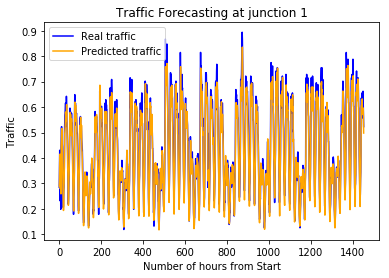

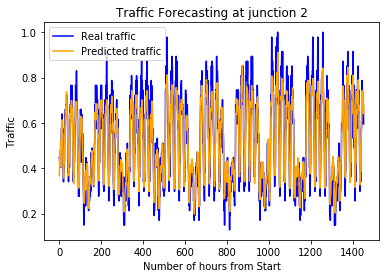

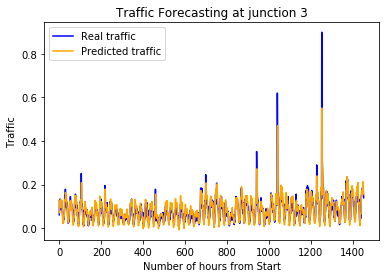

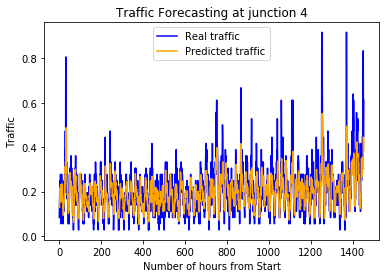

In [35]:
plot_preds(y_test, y_pred)

In [36]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [37]:
rmse(y_test, y_pred)

0.058441390610373595

## Validation by feeding predicted values

In [38]:
def pred_seq(model, to_pred, window_size):
    num_preds = to_pred.shape[0]
    current = to_pred[0]
    predicted = []
    for i in range(num_preds):
        predicted.append(model.predict(current[np.newaxis,:,:])[0,:])
        current = current[1:]
        current = np.insert(current, [window_size-1], predicted[-1], axis=0)
    return np.asarray(predicted)

### Predictions

In [39]:
set_states(model, RNNs_states)

In [40]:
seqpreds = pred_seq(model, X_test, seq_len)

In [41]:
seqpreds.shape

(1454, 4)

### Plot & score

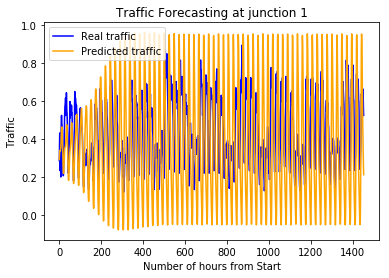

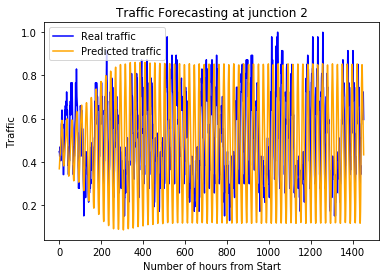

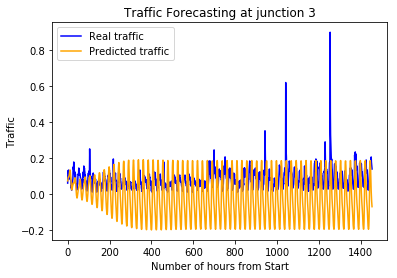

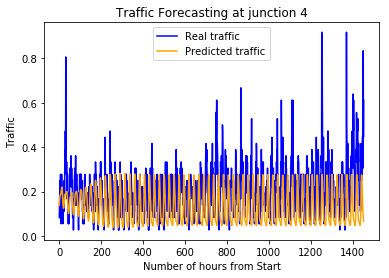

In [42]:
plot_preds(y_test, seqpreds)

In [43]:
rmse(y_test, seqpreds)

0.2594429031762347